This notebook is a narrative exploration of efforts to predict the number of citations per year a paper will receive,
based on data available at time of publication.

A full exploration of 25 different prediction models can be found [here](askfhs)

In this notebook I look to predict the number of citations a paper will received based upon
* the words used in the abstract
* physics-inspired semantic metrics (implemented in github.com/zhafen/cc and employed in Imel & Hafen in prep)
* metadata (publishing journal, number of authors, number of pages, etc.)

The raw code for this analysis can be [found here](https://github.com/zhafen/work-sample).

I aimed to keep this work sample clean, so please reach out if you have questions about details I have not included.

You can jump to punchlines in the analysis via these links:

# User-Defined Parameters

This dictionary contains various user-defined parameters. They will be explained when they are utilized.

In [94]:
pm = dict(
    
    # Data selection
    data_dir = '/Users/zhafen/data/literature_topography',
    region_number = 8,
    convergence_degree = 3,
    kernel_size = 16,
    
    # Features
    numerical_variables = [
        'age',
        'converged_kernel_size',
        'density',
        'fringe_factor',
        'references_count',
        'page_count',
        'log_author_count',
    ],
    categorical_variables = [
        'journal_filtered',
    ],
    semantic_variables = [
        'density',
        'fringe_factor',
    ],
    nonsemantic_variables =  [
        'age',
        'references_count',
        'page_count',
        'log_author_count',
        'journal_filtered',
    ],
    
    # Modeling
    scoring = 'neg_root_mean_squared_error',
    
)

# Data

I use publication abstracts and metadata pulled from the [NASA astrophysics data sytem](https://ui.adsabs.harvard.edu) via [the official API](https://ui.adsabs.harvard.edu/help/api/). The analyzed publications are from a randomly-chosen physics or astrophysics specialization.

I externally preprocessed the abstract data with natural language processing (including tokenizing, stemming, and removing filler words), and each abstract has a corresponding bag-of-words representation.

## Load raw data

In [2]:
import numpy as np
import os

In [3]:
# My custom non-relational-data-management package
import verdict
# My library for NLP analysis of scientific abstracts
from cc import atlas, cartography, utils

In [4]:
# Load summary information.
# I analyzed several randomly chosen specializations ("regions"), of which we are choosing an arbitrary one.
summary_data_fp = os.path.join( pm['data_dir'], 'regions', 'regions_summary.h5' )
data = verdict.Dict.from_hdf5( summary_data_fp )
data_k = data['regions'][str(pm['region_number'])]

In [5]:
# Class for management of abstracts
atlas_dir = os.path.join( pm['data_dir'], 'regions', 'region_{}'.format( pm['region_number'] ) )
a = atlas.Atlas( atlas_dir, load_bibtex=False )

Loading saved atlas data.


0it [00:00, ?it/s]
100%|█████████████████████████████████| 37311/37311 [00:01<00:00, 23371.38it/s]


In [6]:
# Class for analysis of vectorized abstracts
projection = a.vectorize(
    verbose = True,
)
c = cartography.Cartographer( **projection )

Vectorizing text...
Using saved vectorized text...


In [7]:
# Retrieve metrics I calculated in external pre-processing
metrics_fp = os.path.join( atlas_dir, 'topography_metrics.h5' )
metrics = verdict.Dict.from_hdf5( metrics_fp )

In [8]:
# Not all the publications are viable for analysis.
# I've saved information about what publications are viable, and here we load the identifying information.
converged_kernel_size = data_k['converged_kernel_size'][:,-pm['convergence_degree']]
converged = converged_kernel_size >= pm['kernel_size']
publications = c.publications[converged]
inds = np.arange( c.publications.size )[converged]

In [9]:
# Select word vectors
v = c.vectors[inds]

## Format into a DataFrame

In [10]:
import copy
import pandas as pd
import warnings

In [11]:
# Make into a dataframe, for convenience.
df_data = copy.deepcopy( metrics )
df_data['projection_ind'] = inds
df = pd.DataFrame(
    data = df_data._storage,
    index=publications,
)

In [12]:
# Drop publications with no citations.
# This catches all grant submissions, etc.
df = df.loc[np.invert( np.isclose( df['citations_per_year'], 0. ) )]

In [13]:
# Add logscale versions for some variables
for column in [ 'density', 'citations_per_year', ]:
    df['log_{}'.format( column )] = np.log10( df[column] )

In [14]:
# Drop columns for which we're missing abstract data (will show up as a nan in density)
df.dropna(subset=['density',], inplace=True)

## Derive or retrieve additional quantities

In [15]:
import tqdm

### ADS metadata

In [16]:
citation_keys = []
additional_data = {
    'references_count': [],
    'pages': [],
    'author': [],
    'journal': [],
    'title': [],
    'abstract_character_count': [],
    'entry_date': [],
}
for citation_key, p in tqdm.tqdm( a.data.items() ):
    
    citation_keys.append( citation_key )
    
    # number of references
    if p.references is None:
        additional_data['references_count'].append( 0 )
    else:
        additional_data['references_count'].append( len( p.references ) )
    
    # Citation info
    for key in [ 'pages', 'author', 'journal', 'title' ]:
        try:
            additional_data[key].append( p.citation[key] )
        except KeyError:
            additional_data[key].append( pd.NA )
            
    # Abstract
    additional_data['abstract_character_count'].append( len( p.abstract_str() ) )
    
    # Entry date
    additional_data['entry_date'].append( p.entry_date )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37311/37311 [00:02<00:00, 15457.99it/s]


In [17]:
# Convert to datetime
additional_data['entry_date'] = pd.to_datetime( additional_data['entry_date'] )

In [18]:
# Join it onto the existing dataframe
additional_df = pd.DataFrame( data=additional_data, index=citation_keys )
df = df.join( additional_df )

### Index

In [19]:
df['ind'] = np.arange( df.index.size )

### Page count

In [20]:
# Setup data structurs
df['page_count'] = np.full( len( df ), np.nan )

In [21]:
# Get rid of the "L" in front of the pages for publications submitted to letters.
pages_str = df['pages'].str.replace( 'L|P', '' )

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_27855/1933168570.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pages_str = df['pages'].str.replace( 'L|P', '' )


In [22]:
# Split into two to take the difference
pages_split = pages_str.str.split( '-', expand=True )

In [23]:
# Identify the parseable data
is_not_none = np.invert( pages_split[1].isnull() )
is_numeric = pages_split[1].str.isnumeric()
is_page_range = is_not_none & is_numeric

In [24]:
# For the valid page ranges, set the page count
df.loc[is_page_range,'page_count'] = (
    pages_split[1].loc[is_page_range].astype( int )
    - pages_split[0].loc[is_page_range].astype( int )
)

In [25]:
# There can be one or two edge cases where there's a negative page count because of the formatting
df.loc[df['page_count']<0,'page_count'] = np.nan

### Author count

In [26]:
df['author_count'] = df['author'].str.split( ' and ' ).apply( len )
df['log_author_count'] = df['author_count'].apply( np.log10 )

### Title character count

In [27]:
df['title_character_count'] = df['title'].str.len()

### Journals, filtered

In [28]:
# Find the most common journals
df_grouped = df.groupby( 'journal' )
journal_entry_count = df_grouped.size().sort_values( ascending=False )
most_common_journals = journal_entry_count.iloc[:5].index

In [29]:
most_common_journals

Index(['\apj', '\mnras', '\aap', '\aj', '\apjl'], dtype='object', name='journal')

In [30]:
# Make a new column accordingly
df['journal_filtered'] = df['journal'].copy()
is_not_common_journal = np.invert( df['journal'].isin( most_common_journals ) )
df.loc[is_not_common_journal,'journal_filtered'] = 'other'
df.loc[df['journal'].isna(),'journal_filtered'] = 'other'

### Word vectors

In [31]:
v = c.vectors[df['projection_ind']]

## Summarize data

There are two main data containers:
`df`, which contains all the metadata and derived quantities,
and `v`, which contains the word vectors.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7359 entries, 2004JMOp...51.1447V to 1972ApJ...175L..73S
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   age                        7359 non-null   float64            
 1   citations_per_year         7359 non-null   float64            
 2   converged_kernel_size      7359 non-null   int32              
 3   density                    7359 non-null   float64            
 4   fringe_factor              7359 non-null   float64            
 5   kernel_constant_asymmetry  7359 non-null   float64            
 6   smoothing_length           7359 non-null   float64            
 7   projection_ind             7359 non-null   int64              
 8   log_density                7359 non-null   float64            
 9   log_citations_per_year     7359 non-null   float64            
 10  references_count           7359 non-null   i

In [33]:
df.head()

,age,citations_per_year,converged_kernel_size,density,fringe_factor,kernel_constant_asymmetry,smoothing_length,projection_ind,log_density,log_citations_per_year,...,journal,title,abstract_character_count,entry_date,ind,page_count,author_count,log_author_count,title_character_count,journal_filtered
2004JMOp...51.1447V,18.033916,2.495301,22,13.197566,0.679266,10.868260,1.212345,2,1.120494,0.397123,...,Journal of Modern Optics,{Ultrafast superconducting single-photon detec...,1173,2005-05-11 00:00:00+00:00,0,11.0,13,1.113943,103,other
2002MNRAS.336.1129B,20.556883,1.070202,57,13.189905,0.694470,11.111526,1.213049,3,1.120242,0.029466,...,\mnras,{STJ observations of the eclipsing polar HU Aqr},1063,2002-11-02 00:00:00+00:00,1,9.0,9,0.954243,48,\mnras
2002OptEn..41.1170V,20.855476,0.671287,56,13.394224,0.696136,11.138178,1.194545,4,1.126918,-0.173092,...,Optical Engineering,{Superconducting tunnel junctions as photon-co...,1532,2002-07-16 00:00:00+00:00,2,14.0,5,0.698970,110,other
2001MNRAS.324..899P,21.784125,1.606676,23,13.020577,0.660474,10.567585,1.228824,5,1.114630,0.205928,...,\mnras,{High-speed energy-resolved STJ photometry of ...,1523,2001-08-11 00:00:00+00:00,3,10.0,7,0.845098,74,\mnras
1999MNRAS.309..379W,23.531848,1.614834,79,13.100298,0.671835,10.749364,1.221346,7,1.117281,0.208128,...,\mnras,{The seeing at the William Herschel Telescope},512,1999-11-12 00:00:00+00:00,4,8.0,4,0.602060,46,\mnras


In [34]:
v.shape

(7359, 30286)

## Split testing and training data

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# Split dataframe
df_train, df_test = train_test_split( df, test_size=0.2, random_state=42 )

In [115]:
# Split input
X_train_df = df_train[pm['numerical_variables'] + pm['categorical_variables']]
X_test_df = df_test[pm['numerical_variables'] + pm['categorical_variables']]

In [38]:
# Split word vector input
v_train = v[df_train['ind']]
v_test = v[df_test['ind']]

In [39]:
# Split output
y_train = df_train['log_citations_per_year'].values
y_test = df_test['log_citations_per_year'].values

In [40]:
# Split semantic input
M_train = df_train[pm['semantic_variables']].values
M_test = df_test[pm['semantic_variables']].values

# Exploratory Data Analysis

I've explored this dataset thoroughly elsewhere, so here I'll just visually summarize the dataset.

In [41]:
import seaborn as sns

sns.set_style( 'whitegrid' )

## Citations per year

<AxesSubplot: xlabel='log_citations_per_year', ylabel='Count'>

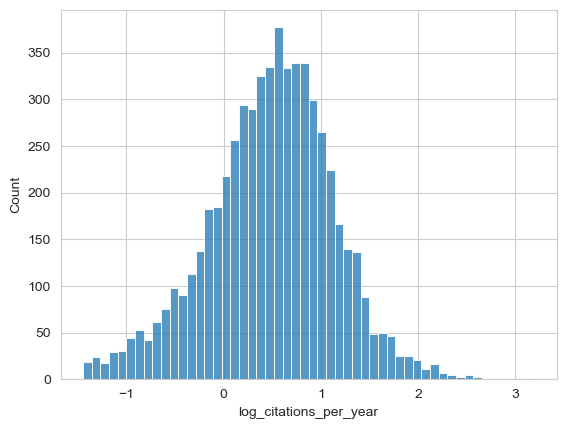

In [42]:
sns.histplot(
    df_train,
    x = 'log_citations_per_year',
)

## Numerical variables

(0.0, 40.0)

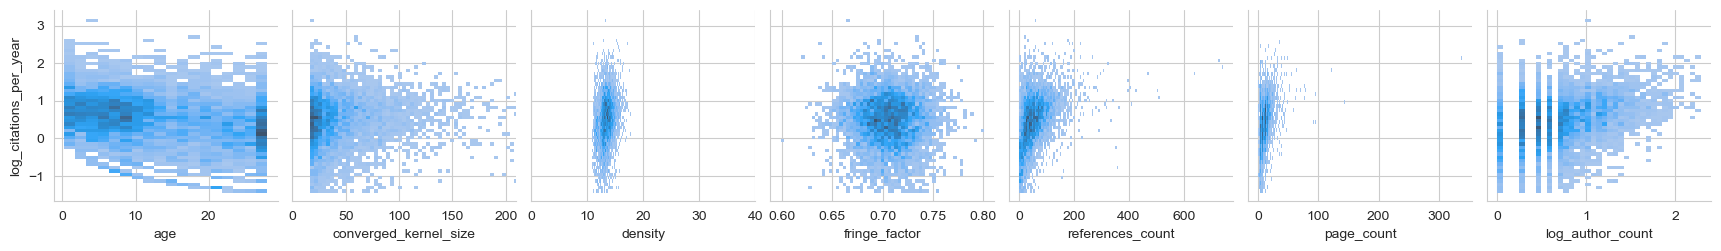

In [43]:
pairplot = sns.pairplot(
    df_train,
    x_vars = pm['numerical_variables'],
    y_vars = [ 'log_citations_per_year',],
    kind = 'hist',
    # plot_kws = { 'line_kws': { 'color': 'k', }, },
)
pairplot.axes[0,1].set_xlim( 0, 210 )
pairplot.axes[0,2].set_xlim( 0, 40 )

## Categorical variable

<AxesSubplot: xlabel='journal_filtered', ylabel='log_citations_per_year'>

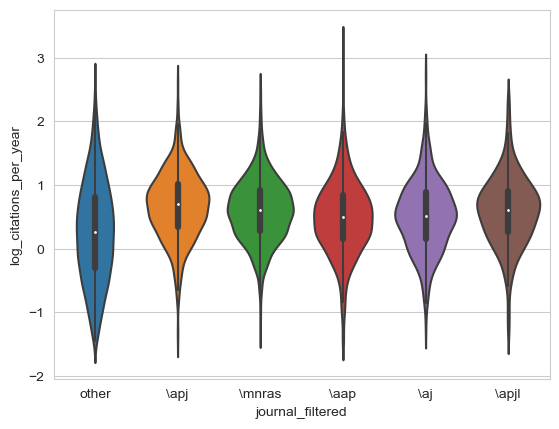

In [44]:
sns.violinplot(
    df_train,
    x = 'journal_filtered',
    y = 'log_citations_per_year',
)

# Modeling

## Preprocessing

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, KFold

In [46]:
# Two things for our numerical variables:
# Imputation of missing values and scaling by mean and std
numerical_preprocessing = Pipeline(
    [
        ( 'impute', SimpleImputer( strategy='mean' ) ),
        ( 'scale', StandardScaler() ),
    ]
)

In [104]:
# Combine the numerical preprocessing with onehot encoding for the categorical variable
metadata_preprocessing = ColumnTransformer( [
        ( 'numerical', numerical_preprocessing, pm['numerical_variables'] ),
        ( 'onehot', OneHotEncoder(), pm['categorical_variables'] ),
] )

In [48]:
# Preprocessing for word vectors is just scaling
vector_preprocessing = Pipeline(
    [
        ( 'scale', Normalizer() ),
    ]
)

In [49]:
# There is a subset of the numerical variables that I refer to as "semantic".
# These variables contain metrics that measure the relationship of the words in a publication to words in other publications.
semantic_preprocessing = Pipeline(
    [
        ( 'scale', StandardScaler() ),
    ]
)

In [50]:
# Set up a kfold object for cross validation
kfold = KFold(
    n_splits = 5,
    shuffle = True,
    random_state = 1532
)

## A Baseline Model

We use the mean log citations per year as the baseline.

In [51]:
from sklearn.base import BaseEstimator

In [52]:
class Baseline( BaseEstimator ):
    '''The baseline model is just the mean. We put it into a class
    for full consistency with all future models.'''
    
    def fit( self, X , y):
        
        self.estimate = y.mean()
        
    def predict( self, X ):
        
        return np.full( X.shape[0], self.estimate )

model = Baseline()

In [53]:
# Object for storing data
crossvals = {}

In [54]:
# Perform and store cross validation
crossvals['baseline'] = verdict.Dict( cross_validate(
    estimator = model,
    X = X_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

Because the baseline is the mean we expect the RMSE for the individual folds to be similar to the standard deviation of the full sample.

In [55]:
-crossvals['baseline']['test_score']

array([0.64482796, 0.66680128, 0.66007965, 0.63059422, 0.63430133])

In [56]:
sample_mean = y_train.mean()
sample_std = y_train.std()
sample_std

0.6472643986056894

## A Naive Model: Simple Linear Regression

For our first model we'll see if we can just use linear least squares regression with the word vectors as input.
This is a pretty silly model: we're limited to linear order because of the high dimensionality of the word vectors, and it is unlikely that a single line can describe the citation relationship.

In [57]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [58]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'poly', PolynomialFeatures( degree=1 ) ),
        ( 'reg', LinearRegression( fit_intercept=False ) ),
    ]
)

In [59]:
# Perform and store cross validation
crossvals['linear_regression'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

In [60]:
import matplotlib
import matplotlib.pyplot as plt

In [88]:
def rmse_swarmplot( crossval, y_lim=(sample_std-0.15, sample_std+0.15) ):    
    
    # Format data
    df_data = -1. * verdict.Dict( crossvals ).inner_item( 'test_score' )
    crossval_df = pd.DataFrame( df_data._storage ).melt( var_name='model', value_name='rmse' )
    
    # Visualize
    fig = plt.figure( figsize=(len(df_data)*1.5, 3) )
    ax = plt.gca()
    
    # Plot itself
    sns.swarmplot(
        data = crossval_df,
        x = 'model',
        y = 'rmse',
        ax = ax,
    )
    
    # Mark the analytic baseline value for comparison
    ax.axhline(
        sample_std,
        color = '0.5',
        linestyle = '--',
        linewidth = 0.75,
    )

    ax.set_xlabel( 'model' )
    ax.set_ylabel( r'RMSE in log_citations_per_year' )
    
    ax.set_ylim( y_lim )
    
    return fig

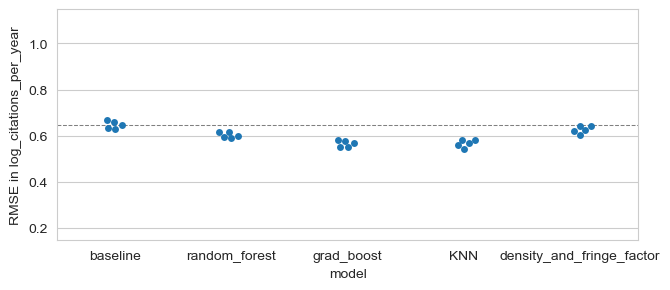

In [83]:
fig = rmse_swarmplot( crossvals, y_lim=(sample_std-0.5, sample_std+0.5) )

No surprise, this model doesn't perform particularly well.

## A Basic Phenomenological Model: Random Forest

For a more-sophisticated phenomenological description of the data, let's try a random forest.

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'reg', RandomForestRegressor( max_depth=3, n_estimators=200 ) ),    ]
)

In [65]:
# Perform and store cross validation
crossvals['random_forest'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

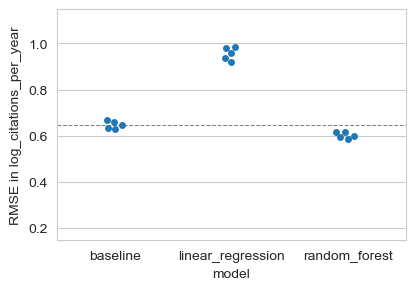

In [66]:
fig = rmse_swarmplot( crossvals )

Better performance than the baseline! We're getting somewhere.

## A Better Phenomoenological Model: Gradient Boosting

If the random forest model went well, how about a gradient boosting model with decision trees as the base?

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

In [68]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'reg', GradientBoostingRegressor() ),
    ]
)

In [69]:
# Perform and store cross validation
crossvals['grad_boost'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

In [70]:
# Let's go ahead and drop the linear regression model so it's not distracting us.
del crossvals['linear_regression']

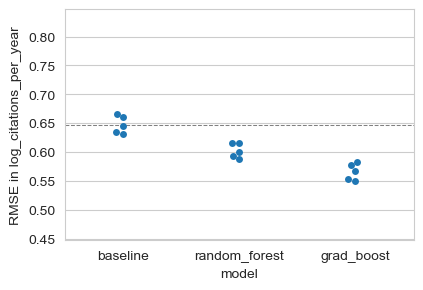

In [71]:
fig = rmse_swarmplot( crossvals, y_lim=(sample_std-0.2, sample_std+0.2) )

Great. We have a model that does noticeably better than the baseline.

In [72]:
print( 'We can predict the number of citations to within a factor of ~{:.2g} on average.'.format( 10.**-crossvals['grad_boost']['test_score'].mean() ) )

We can predict the number of citations to within a factor of ~3.7 on average.


There is still a significant amount of error in the prediction: a factor of a few in predicting the number of citations per year. This is perhaps to be expected: it would be surprising if the main thing driving citation trends could be predicted simply via the words used, with no information about how those words relate to one another (e.g. via an N-gram language model).

## An Informed Model: K Nearest Neighbors

So far we've been treating the word vectors as generic data. To further improve our model, and add some explanatory power, let's make use of our knowledge about what the vectors _are_: the language used in a scientific abstract.

Here's a simple hypothesis:
The number of citations a paper receives correlates with the number of citations papers on similar topics (i.e. using similar words) receive. Fortunately this is a simple, well-defined model: the K Nearest Neighbors model.

In [73]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [74]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'knn', KNeighborsRegressor( n_neighbors=32 ) ),
    ]
)

In [75]:
# Perform a parameter search for the number of neighbors to use
param_grid = {
    'knn__n_neighbors': [ 4, 16, 32, 64, 128, 256, ],
}
search = GridSearchCV( model, param_grid, )
search.fit( v_train, df_train['log_citations_per_year'] )
model = search.best_estimator_
search.best_params_

{'knn__n_neighbors': 16}

In [76]:
# Perform and store cross validation
crossvals['KNN'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

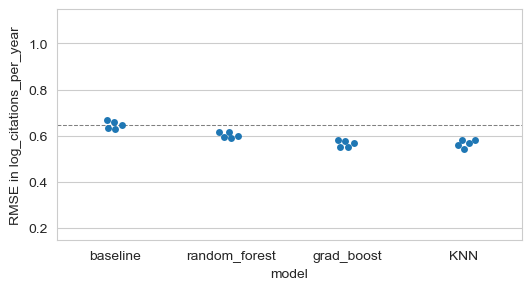

In [77]:
fig = rmse_swarmplot( crossvals )

KNN does comparably well to gradient boosting, but is much more interpretable!

## Another Informed Model: Density and Asymmetry

Related to K Nearest Neighbors, we can ask if the local geometry of the hyperspace is related to citations received. In particular, we'll define two metrics:

density, which tracks the number of similar papers,
$${\rm density} = \frac{K}{{\rm distance\,to\,the\,farthest\,neighbor}}$$

and "fringe factor", which tracks if a paper uses language in a new direction relative to existing similar papers.
$${\rm fringe\,factor} = \frac1K \sum_{i=1}^{K} \frac{\vec v - \vec v_i}{|\vec v - \vec v_i|} $$
The concept of edginess comes from the concept of force balance.

I calculated these quantities in preprocessing.

<AxesSubplot: xlabel='density', ylabel='Count'>

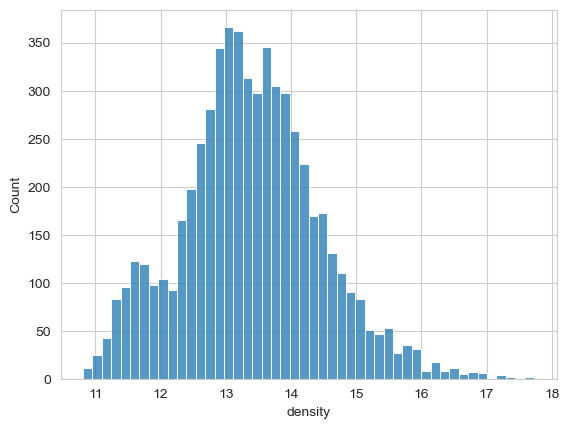

In [78]:
sns.histplot(
    df_train,
    x = 'density',
)

<AxesSubplot: xlabel='fringe_factor', ylabel='Count'>

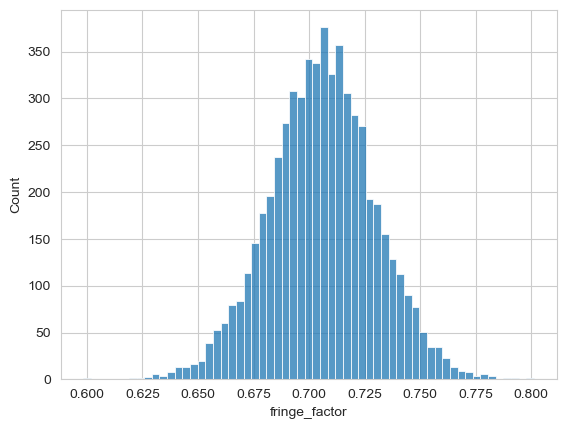

In [79]:
sns.histplot(
    df_train,
    x = 'fringe_factor',
)

Most of the meaningful modeling is in the calculation of these two quantities, so we'll fit a simple linear regression.

In [80]:
semantic_model = Pipeline(
    [
        ( 'preprocessing', semantic_preprocessing ),
        ( 'poly', PolynomialFeatures( degree=1 ) ),
        ( 'reg', LinearRegression( fit_intercept=False ) ),
    ]
)

In [89]:
# Perform and store cross validation
crossvals['density_and_fringe_factor'] = verdict.Dict( cross_validate(
    estimator = semantic_model,
    X = M_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

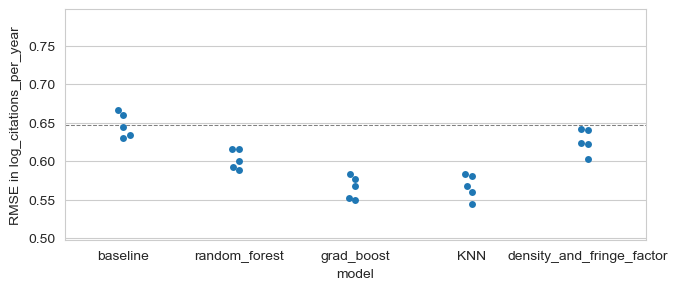

In [90]:
fig = rmse_swarmplot( crossvals )

Regressing on the explanatory variables of density and fringe factor does not give us the best model, but nevertheless holds some predictive power.

## A Model Utilizing Metadata

Our analysis so far has been limited to the word content of the abstract. But presumably the number of citations received is a function of much more than the words employed. I have gathered a number of additional attributes for each publication, and we will regress onto those too.

In [100]:
df_train[pm['nonsemantic_variables']]

,age,references_count,page_count,log_author_count,journal_filtered
1984A&AS...56...79B,27.810758,20,7.0,0.698970,other
2015IJMPD..2430011F,7.859864,160,NaN,0.000000,other
1998ApJ...498..106M,25.024810,63,10.0,0.477121,\apj
2023ApJ...942...36K,0.362184,110,NaN,1.477121,\apj
2021MNRAS.500.1323L,2.490682,144,16.0,1.361728,\mnras
...,...,...,...,...,...
2015OExpr..2310786C,8.062578,19,NaN,0.903090,other
2013MNRAS.434.1129K,9.739077,40,8.0,0.778151,\mnras
2003PASP..115..928K,19.822730,104,24.0,1.361728,other
2021ApJ...915...21R,1.877061,86,NaN,0.845098,\apj


I will regress with gradient boosting, but in exploratory modeling I discoverd that most other reasonable ML models perform similarly.

In [111]:
metadata_model = Pipeline(
    [
        ( 'preprocessing', metadata_preprocessing ),
        ( 'reg', GradientBoostingRegressor() ),
    ]
)

In [116]:
# Perform and store cross validation
crossvals['metadata'] = verdict.Dict( cross_validate(
    estimator = metadata_model,
    X = X_train_df,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

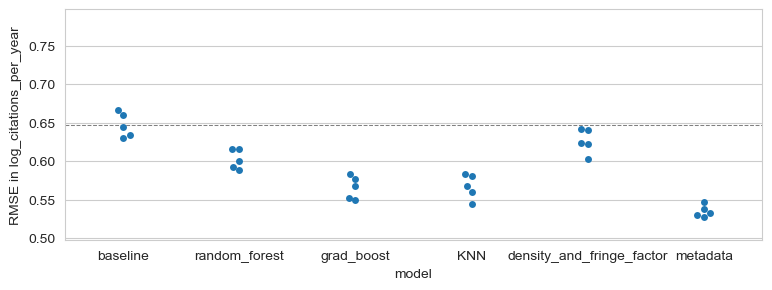

In [117]:
fig = rmse_swarmplot( crossvals )

The metadata contains a lot of information useful for predicting citations!

## A Neural Net

We'll wrap up our individual models with a simple neural net regressed onto the word vectors.

In [118]:
import keras

2023-06-23 16:43:26.113699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [130]:
# Simple multilayer model
neural_net = keras.models.Sequential()
neural_net.add( keras.layers.Input( shape=(v_train.shape[1],) ) )
neural_net.add( keras.layers.Dense( 16, activation='relu', ) )
neural_net.add( keras.layers.Dense( 16, activation='relu' ) )
neural_net.add( keras.layers.Dense( 1, ) )
neural_net.compile( loss='mean_squared_error' )

In [135]:
# Actually build the model
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'reg', neural_net ),
    ]
)

In [139]:
from sklearn.metrics import mean_squared_error

In [147]:
verdict.Dict( crossvals ).inner_item( 'test_score' )

Dict, {
'baseline' : array([-0.64482796, -0.66680128, -0.66007965, -0.63059422, -0.63430133]),
'random_forest' : array([-0.60049046, -0.61617404, -0.615769  , -0.58811211, -0.59293866]),
'grad_boost' : array([-0.56719873, -0.57706778, -0.5834025 , -0.54936475, -0.55267493]),
'KNN' : array([-0.56745516, -0.58027605, -0.58351969, -0.54438778, -0.56027554]),
'density_and_fringe_factor' : array([-0.62378975, -0.64172012, -0.64107832, -0.60317783, -0.62171307]),
'metadata' : array([-0.53035809, -0.54748205, -0.53790319, -0.53302039, -0.52749763]),
'neural_net' : array([-0.43315552, -0.41535058, -0.38232999, -0.34641663, -0.32201562]),
}

In [152]:
# Perform KFold cross validation
# We could use the exact same code as before, but this allows a little additional control.
crossvals['neural_net'] = {'test_score':[]}
for train_index, test_index in kfold.split(v_train):
        
    # Fit and predict
    model.fit( v_train[train_index].toarray(), y_train[train_index] )
    log_cpy_pred = model.predict( v_train[test_index].toarray() )
    
    # Compare prediction
    rmse = -np.sqrt( mean_squared_error( y_train[test_index], log_cpy_pred ) )
    crossvals['neural_net']['test_score'].append( rmse )
crossvals['neural_net']['test_score'] = np.array( crossvals['neural_net']['test_score'] )

37/37 [==============================] - 0s 2ms/step


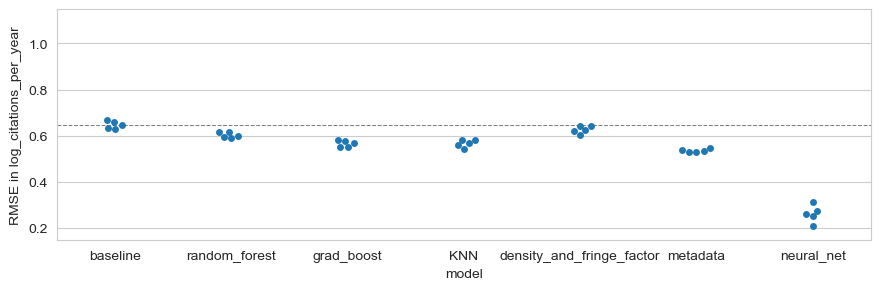

In [153]:
fig = rmse_swarmplot( crossvals, y_lim=(sample_std-0.5, sample_std+0.5 ) )

While arguably the biggest blackbox of the considered models, the simple neural net performs remarkably well for predicting citations given the words used, at least on the training set.

## Putting it All Together: A Voting Model

In [154]:
from sklearn.ensemble import VotingRegressor

In [155]:
VotingRegressor?

Init signature: VotingRegressor(estimators, *, weights=None, n_jobs=None, verbose=False)
Docstring:     
Prediction voting regressor for unfitted estimators.

A voting regressor is an ensemble meta-estimator that fits several base
regressors, each on the whole dataset. Then it averages the individual
predictions to form a final prediction.

Read more in the :ref:`User Guide <voting_regressor>`.

.. versionadded:: 0.21

Parameters
----------
estimators : list of (str, estimator) tuples
    Invoking the ``fit`` method on the ``VotingRegressor`` will fit clones
    of those original estimators that will be stored in the class attribute
    ``self.estimators_``. An estimator can be set to ``'drop'`` using
    :meth:`set_params`.

    .. versionchanged:: 0.21
        ``'drop'`` is accepted. Using None was deprecated in 0.22 and
        support was removed in 0.24.

weights : array-like of shape (n_regressors,), default=None
    Sequence of weights (`float` or `int`) to weight the occurrence

# Takeaways

* Even the best model can't predict citations that well. Our minimum RMSE suggests we will routinely misestimate by a factor of X

# Credits

Utilized python packages include:
* [ads](https://github.com/andycasey/ads)
* nltk